# Assignment 4A

## Part 2:

### Declare Imports

In [19]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dist
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.datasets import SVHN

from matplotlib import pyplot as plt
import matplotlib.style
import matplotlib as mpl
import numpy as np

### CUDA

In [20]:
# set random seeds
torch.manual_seed(1)
torch.cuda.manual_seed(1)

# setup device cuda vs. cpu
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

### Load Dataset

In [21]:
batch_size = 256

In [22]:
transform = transforms.Compose(
    [transforms.ToTensor()])

mnist_dstrain = MNIST(root='./data', train=True, download=True, transform=transform)
mnist_dstest = MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(dataset=mnist_dstrain, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=cuda)
test_loader = DataLoader(dataset=mnist_dstest, batch_size=4, shuffle=True, num_workers=0, pin_memory=cuda)

dataset_used = "MNIST"
dataset_img_size = 28

# svhn_dstrain = SVHN(root='./data_svhn', split="train", download=True, transform=transform)
# svhn_dstest = SVHN(root='./data_svhn', split="test", transform=transform)
#
# train_loader = DataLoader(dataset=svhn_dstrain, batch_size=64, shuffle=True, num_workers=0, pin_memory=cuda)
# test_loader = DataLoader(dataset=svhn_dstest, batch_size=64, shuffle=True, num_workers=0, pin_memory=cuda)
#
# dataset_used = "SVHN"
# dataset_img_size = 32

### Methods for visualization

In [23]:
def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)

mpl.rcParams['image.cmap'] = 'viridis'

def display_images(in_, out, label, n=1, count=False, size = 28):
    title_set = False
    for N in range(n):
      if in_ is not None:
        in_pic = in_.data.cpu().view(-1, size, size)
        plt.figure(figsize=(18, 4))
        if not title_set:
          plt.suptitle(label, color='w', fontsize=20)
          title_set = True
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(in_pic[i+4*N])
            plt.axis('off')
      if out is not None:
        if dataset_used == "MNIST":
            out_pic = out.data.cpu().view(-1, size, size)
        else:
            print(out.data.cpu().shape)
            out_pic = out.data.cpu().view(-1, 3,  size, size)
            out_pic = out_pic.permute(0, 2, 3, 1)
        plt.figure(figsize=(18, 6))
        if not title_set:
          plt.suptitle(label, color='w', fontsize=20)
          title_set = True
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

def plot_samples_grid(ds_loader, n_rows=8, n_cols=8, fig_size=8, img_dim=28, title=None):

  f, axarr = plt.subplots(n_rows, n_cols, figsize=(fig_size, fig_size))

  images, labels = next(iter(ds_loader))
  if img_dim != 28:
    images = images.permute(0, 2, 3, 1)

  for i, ax in enumerate(axarr.flat):
      if img_dim != 28:
            ax.imshow(images[i])
      else:
          ax.imshow(images[i].view(img_dim, img_dim))
      ax.axis('off')

  plt.suptitle(title)
  plt.show()


In [24]:
def binarizer(x):
  intensities = transforms.ToTensor()(x)
  t = torch.Tensor([0.5])
  out = (intensities >= t).float() * 1
  return out

# define the train and test datasets
bin_ds_train = MNIST("./bin_data", train=True, transform=binarizer, download=True)
bin_ds_test = MNIST("./bin_data", train=False, transform=binarizer)

# data loaders to load data in batches from the datasets
bin_train_loader = DataLoader(dataset=bin_ds_train, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=cuda)
bin_test_loader = DataLoader(dataset=bin_ds_test, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=cuda)




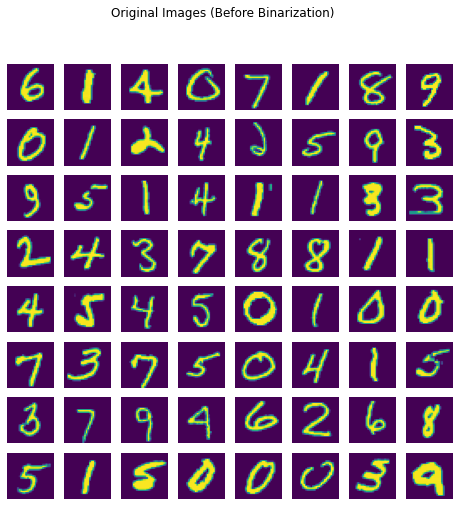

In [25]:
plot_samples_grid(train_loader, title='Original Images (Before Binarization)', img_dim=dataset_img_size)

### Definitions

In [26]:
PI = torch.from_numpy(np.asarray(np.pi))
def log_categorical(x, p, num_classes=784, reduction=None, dim=None):
    x_one_hot = F.one_hot(x.long(), num_classes=num_classes)
    print(f"Shape of x = {x.shape}")
    print(f"Shape of p = {p.shape}")
    print(f"Shape of x_one_hot = {x_one_hot.shape}")
    print(f"Calculation shape = {(torch.log(torch.clamp(p, 1.e-5, 1. - 1.e-5))).shape}")
    log_p = x_one_hot * torch.log(torch.clamp(p, 1.e-5, 1. - 1.e-5))
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

# def log_normal(n, mu, sigma):
#     std = torch.exp(sigma)
#     mean = mu
#     norm_dist = torch.distributions.Normal(mean, std)
#
#     pxz_log = norm_dist.log_prob(n)
#     return pxz_log

def log_normal(x, mu=None, log_var=None, reduction=None, dim=None, standard = True):
    D = x.shape[1]
    if standard:
        log_p = -0.5 * D * torch.log(2. * PI) - 0.5 * x ** 2.
    else:
        log_p = -0.5 * D * torch.log(2. * PI) - 0.5 * log_var - 0.5 * torch.exp(-log_var) * (x - mu)**2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

### VAE Architecture

In [27]:
class VAE(nn.Module):

    def __init__(self, D, M):
        super(VAE, self).__init__()
        self.D = D
        self.M = M
        self.encoder = nn.Sequential(
            nn.Linear(in_features=self.D, out_features=400),
            nn.ReLU(),
            nn.Linear(in_features=400, out_features=self.M*2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=self.M, out_features=400),
            nn.ReLU(),
            nn.Linear(in_features=400, out_features=self.D),
            nn.Sigmoid(),
        )

    def reparameterize(self, mu, log_std):
        std = torch.exp(log_std)
        eps = torch.randn_like(std)
        z = mu + (eps * std)
        return z

    def encode(self, x):
        if dataset_used == "MNIST":
            mu_logvar = self.encoder(x.view(-1, self.D)).view(-1, 2, self.M)
        else:
            mu_logvar = self.encoder(x.view(-1, 3, self.D)).view(-1, 2, self.M)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        return mu, logvar

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # encoder
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)

        #decoder
        x_hat = self.decode(z)


        RE = nn.functional.binary_cross_entropy(x_hat, x.view(-1, self.D), reduction='sum')
        KL = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

        return (RE + KL), x_hat, mu, logvar

    def sample(self, n_samples):
        if dataset_used == "MNIST":
            z = torch.randn((n_samples, self.M)).to(device)
        else:
            z = torch.randn((n_samples, 3, self.M)).to(device)
        return self.decode(z)


### inception

In [28]:
%%capture
model_inception_v3 = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model_inception_v3.eval()

### Model Creation

In [29]:
if dataset_used == "SVHN":
    model = VAE(1024, 20).to(device)
else:
    model = VAE(784, 20).to(device)

In [30]:
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

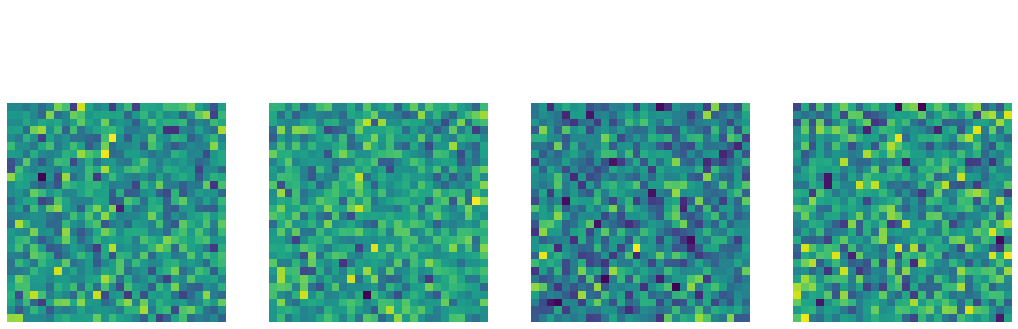

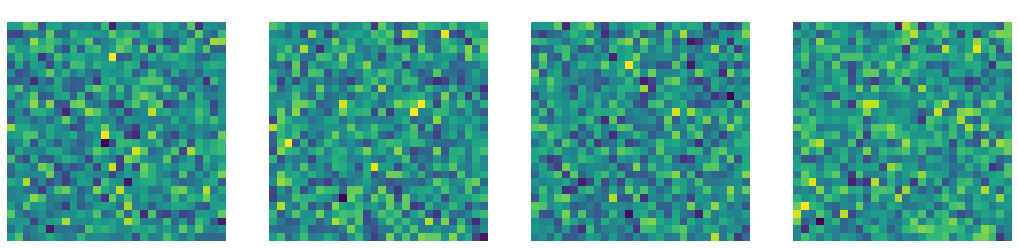

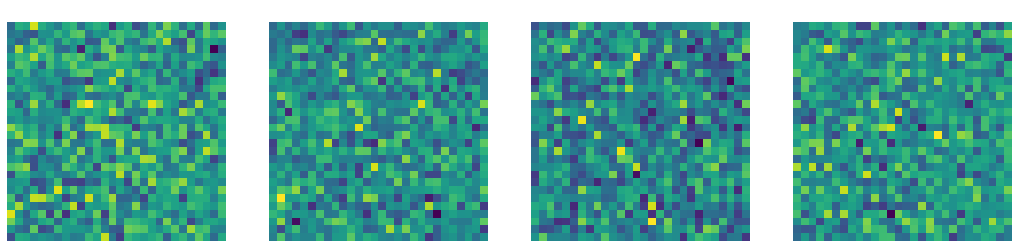

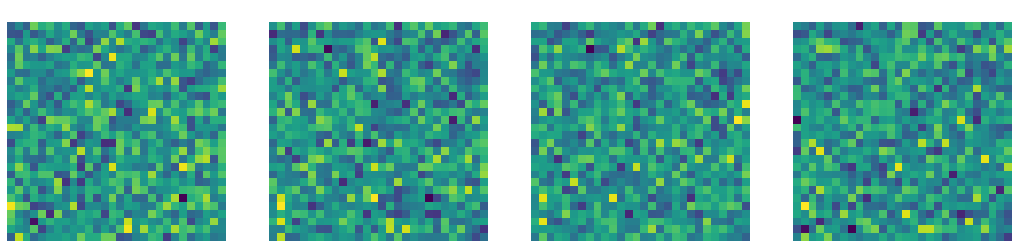

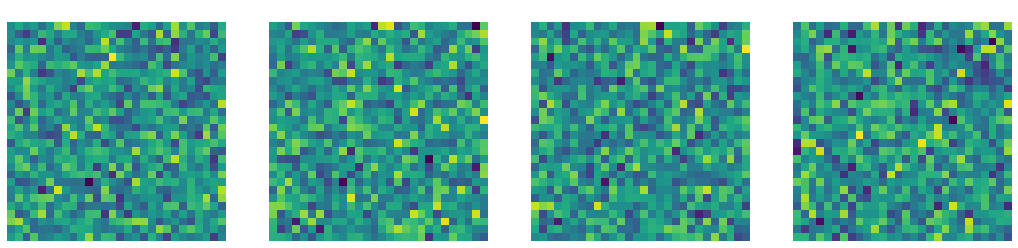

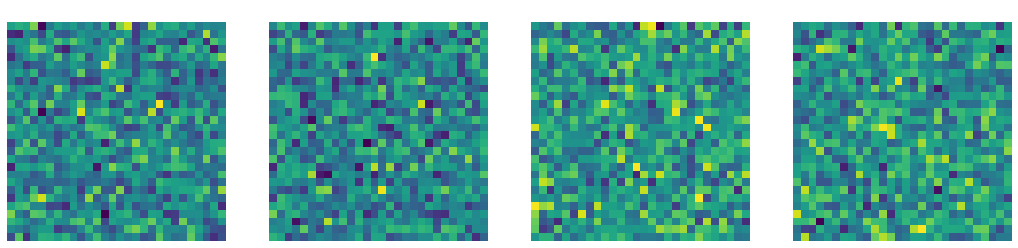

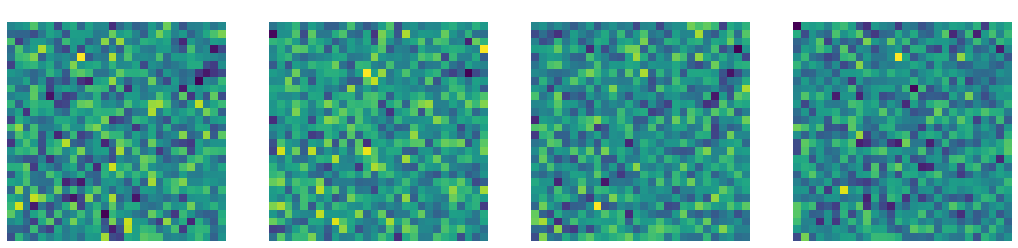

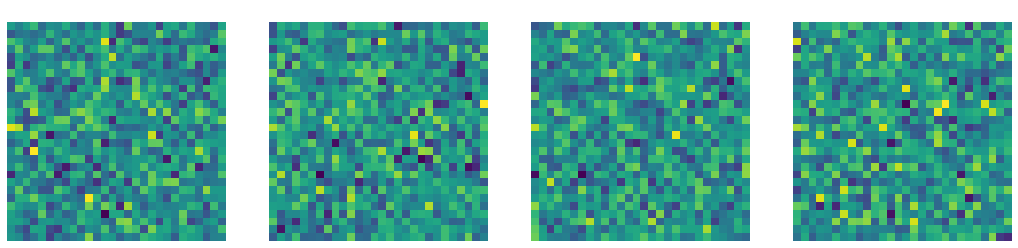

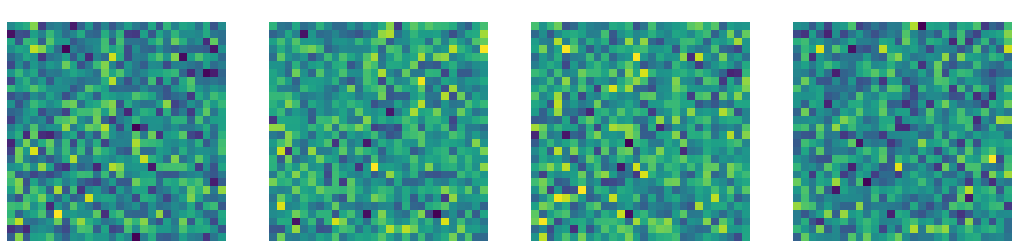

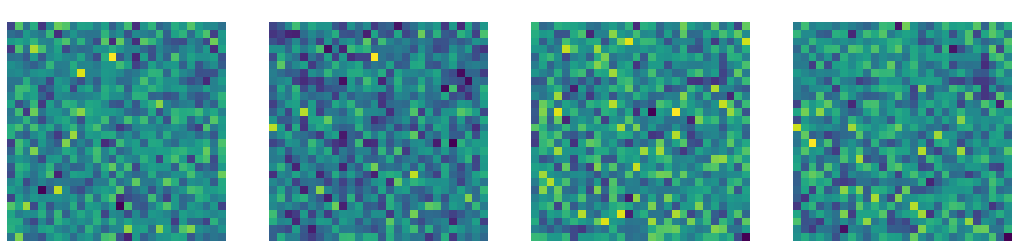

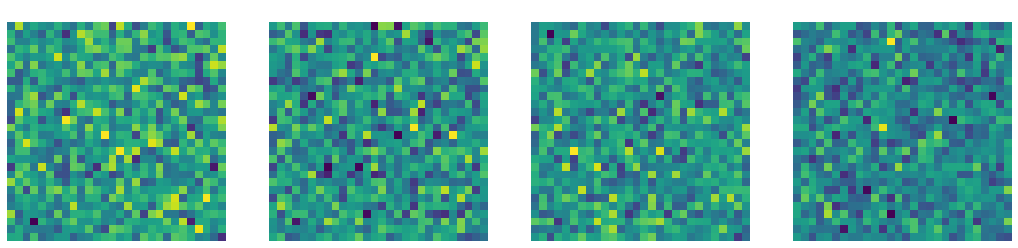

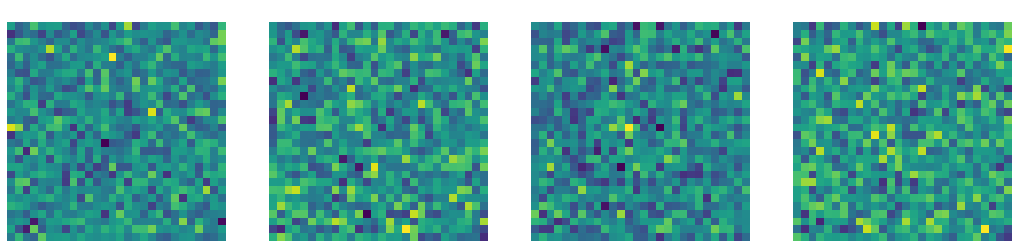

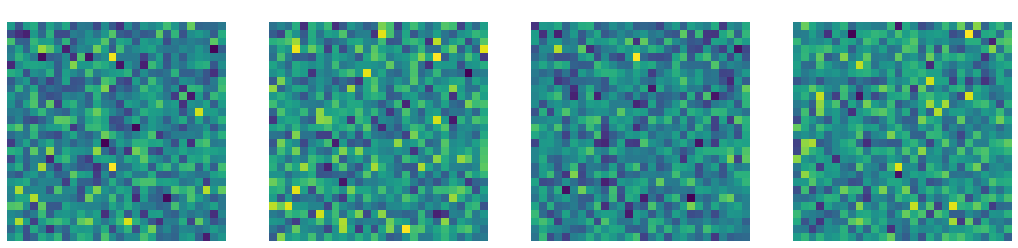

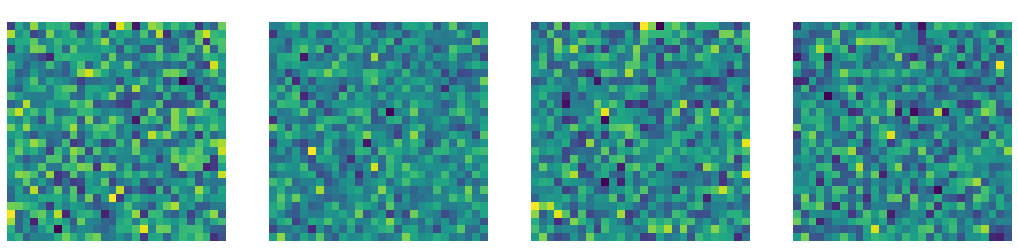

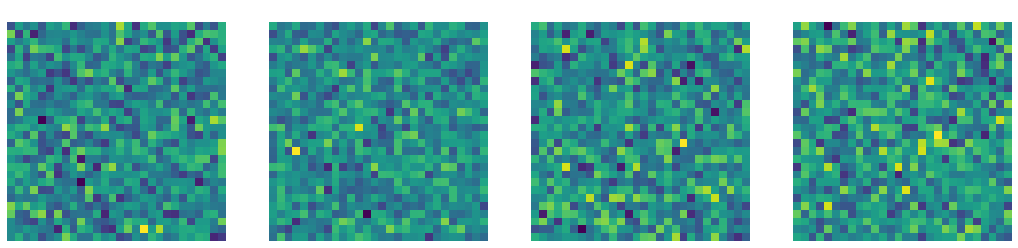

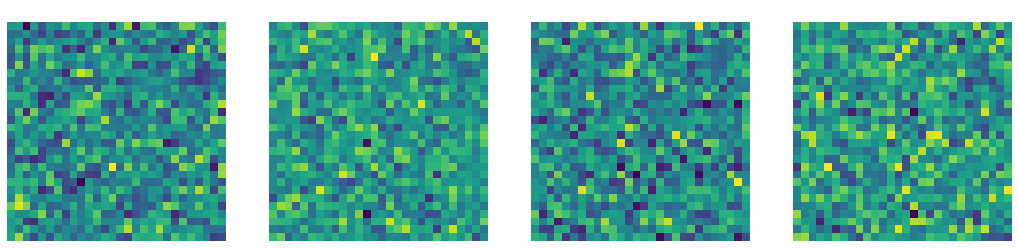

In [31]:
samples = model.sample(64)
display_images(None, samples, 'Generated Samples - untrained Model', 64 // 4, count=True, size=dataset_img_size)

In [32]:
with torch.no_grad():
    model.eval()

    images, _ = next(iter(train_loader))
    only_64 = images[0:64, :, :, :]
    only_64 = only_64.to(device)
    elbo_64_untrained, model_x_hat, mu, logvar = model(only_64)
    elbo_64_untrained = elbo_64_untrained.item()

print(f'ELBO of 64 samples using the untrained model: {elbo_64_untrained:.4f}')

ELBO of 64 samples using the untrained model: 35272.7305


In [33]:
samples.shape

torch.Size([64, 784])

In [34]:
# performs one epoch of training and returns the training loss for this epoch
def train():
  model.train()
  train_loss = 0
  for x, _ in train_loader:
    x = x.to(device)
    loss, model_x_hat, mu, logvar = model(x)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  return train_loss

def test(epoch):
  means, logvars, labels, images = list(), list(), list(), list()
  test_loss = 0
  with torch.no_grad():
    model.eval()
    for x, y in train_loader:
      x = x.to(device)
      # forward
      loss, x_hat, mu, logvar = model(x)
      test_loss += loss.item()
      # log
      means.append(mu.detach())
      logvars.append(logvar.detach())
      labels.append(y.detach())
      images.append(x.detach())
  if epoch % 10 == 0:
    display_images(None, x_hat, f'Epoch {epoch} - Reconstructed Images', 1, size=dataset_img_size)
  return test_loss, means, logvars, labels, images

In [35]:
# Training the model
epochs = 50
codes = dict(μ=list(), logσ2=list(), y=list(), x=list())
for epoch in range(1, epochs+1):

    # train for one epoch
    train_loss = train()

    # print the train loss for the epoch
    print(f'====> Epoch: {epoch} Average train loss: {train_loss / len(train_loader.dataset):.4f}')
    #
    # test_loss, means, logvars, labels, images = test(epoch)
    #
    # codes['μ'].append(torch.cat(means))
    # codes['logσ2'].append(torch.cat(logvars))
    # codes['y'].append(torch.cat(labels))
    # codes['x'].append(torch.cat(images))

====> Epoch: 1 Average train loss: 192.9917
====> Epoch: 2 Average train loss: 126.0454
====> Epoch: 3 Average train loss: 109.4065
====> Epoch: 4 Average train loss: 102.7018
====> Epoch: 5 Average train loss: 99.5039
====> Epoch: 6 Average train loss: 97.5017
====> Epoch: 7 Average train loss: 96.0712
====> Epoch: 8 Average train loss: 95.0032
====> Epoch: 9 Average train loss: 94.1779
====> Epoch: 10 Average train loss: 93.5127
====> Epoch: 11 Average train loss: 92.9249
====> Epoch: 12 Average train loss: 92.3977
====> Epoch: 13 Average train loss: 92.0124
====> Epoch: 14 Average train loss: 91.6136
====> Epoch: 15 Average train loss: 91.2955
====> Epoch: 16 Average train loss: 90.9910
====> Epoch: 17 Average train loss: 90.7673
====> Epoch: 18 Average train loss: 90.5391
====> Epoch: 19 Average train loss: 90.3051
====> Epoch: 20 Average train loss: 90.0958
====> Epoch: 21 Average train loss: 89.9064
====> Epoch: 22 Average train loss: 89.7467
====> Epoch: 23 Average train loss: 8

In [36]:
# Save
if dataset_used == "MNIST":
    torch.save(model.state_dict(), 'vae-gauss.pt')
else:
    torch.save(model.state_dict(), 'vae-gauss-SVHN.pt')

In [37]:
#Load
if dataset_used == "MNIST":
    model = VAE(784, 20).to(device)
    model.load_state_dict(torch.load('vae-gauss.pt'))
else:
    model = VAE(1024, 20).to(device)
    model.load_state_dict(torch.load('vae-gauss-SVHN.pt'))

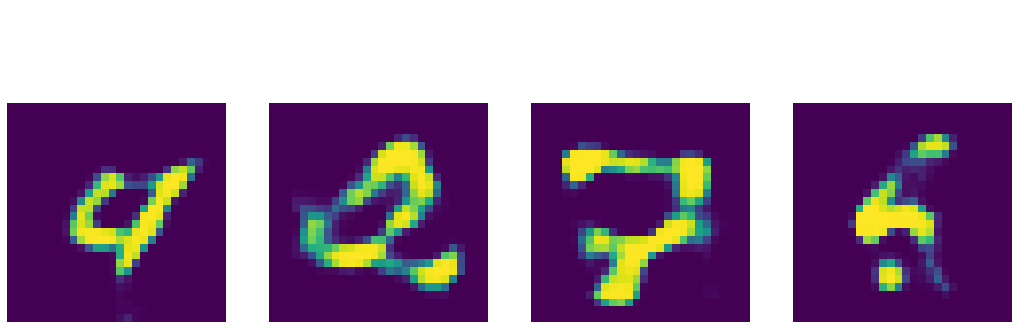

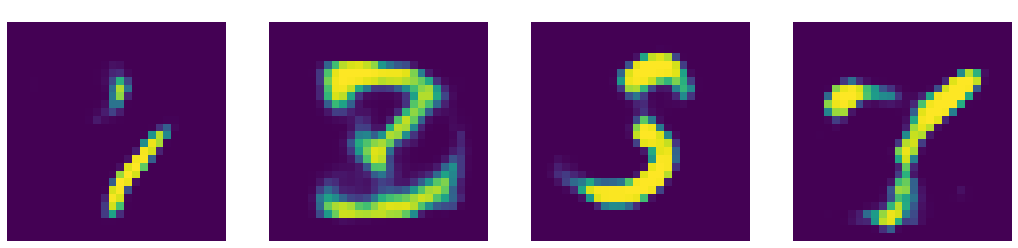

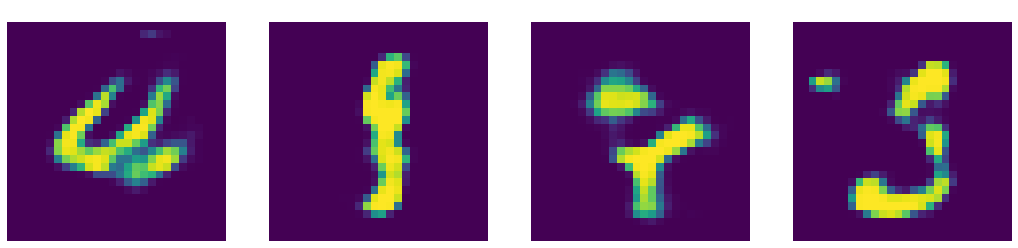

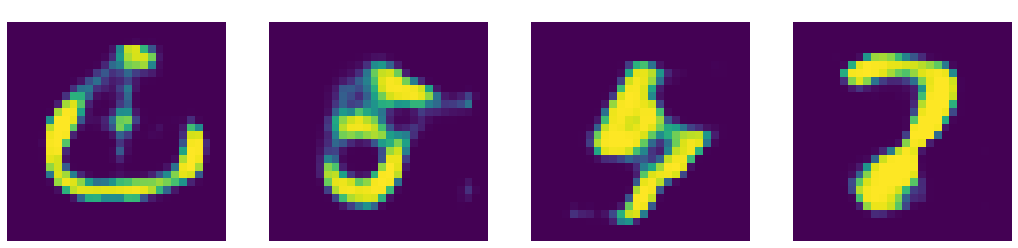

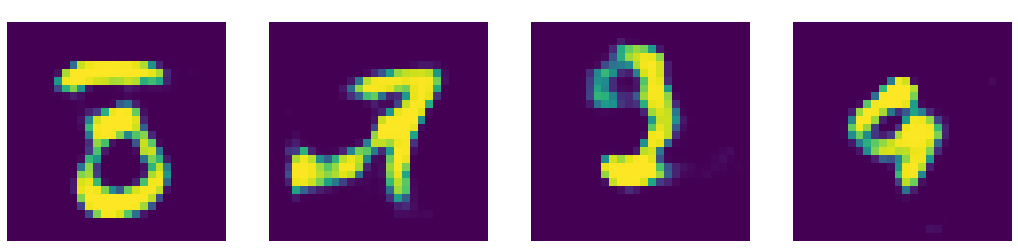

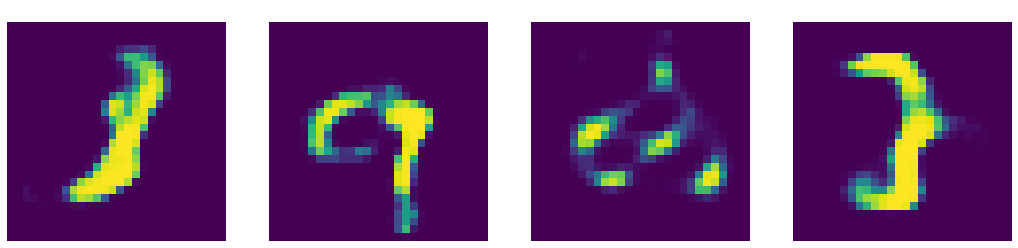

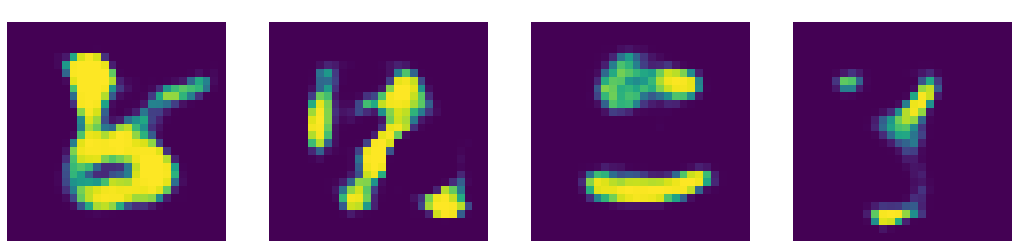

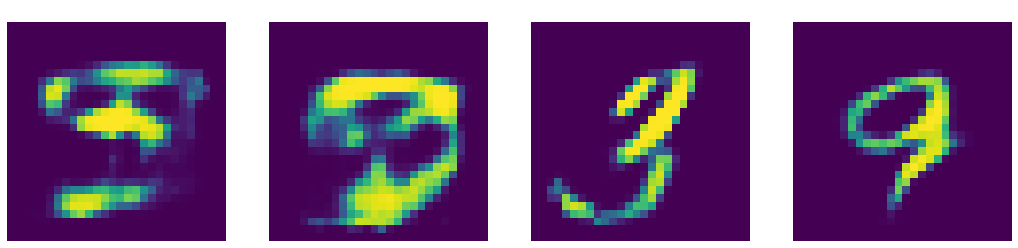

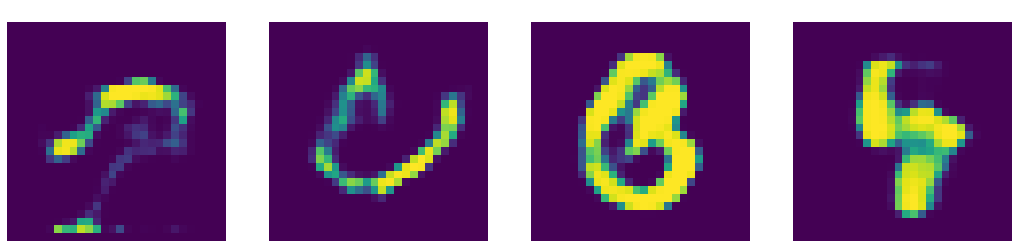

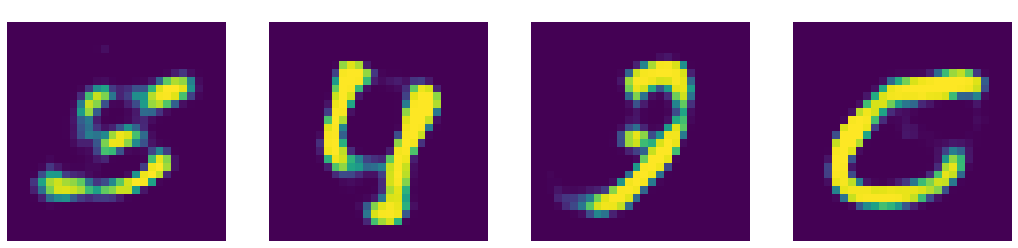

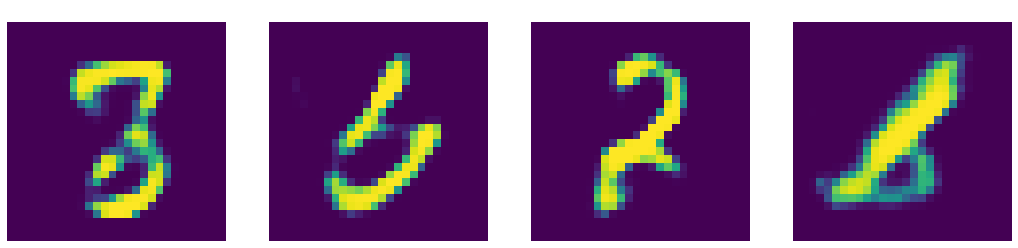

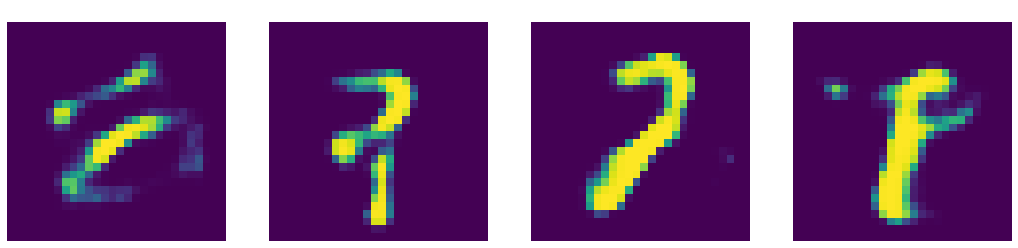

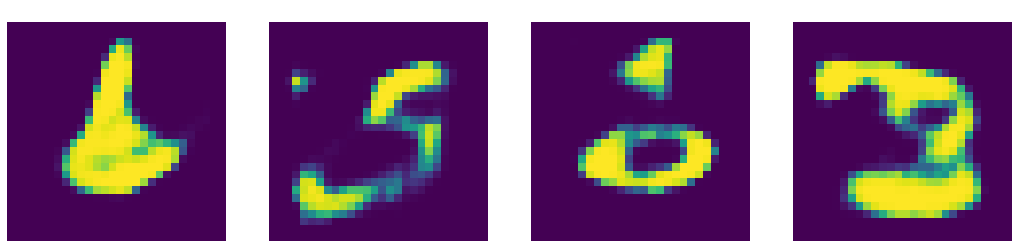

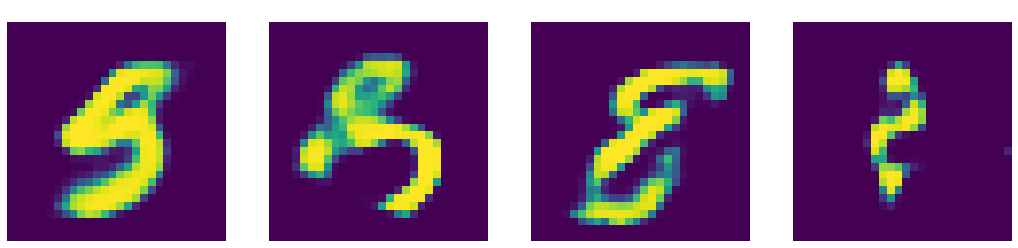

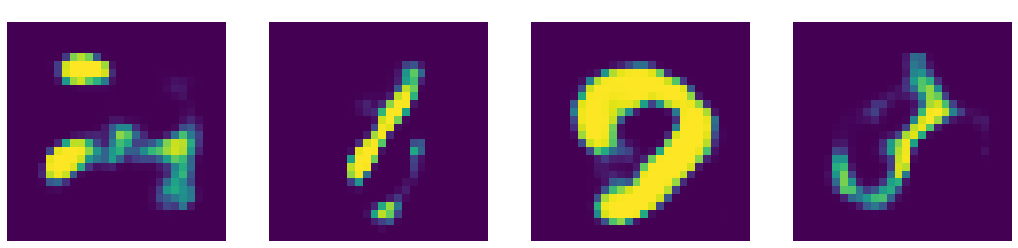

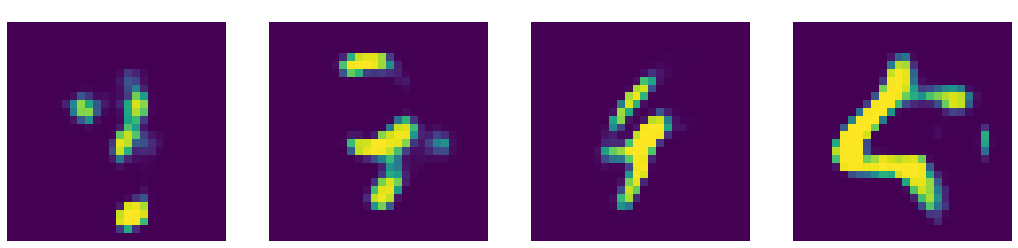

In [38]:
samples = model.sample(64)
display_images(None, samples, 'Generated Samples - Trained Model', 64 // 4, count=True, size=dataset_img_size)

In [39]:
def resize_images(images):
    final_imgs = []
    for image in images:
        image = image.repeat(3,1,1)
        trans = transforms.Compose([transforms.Resize(299)])
        final_img = trans(image)
        final_img = final_img.to(torch.uint8)
        final_imgs.append(final_img)
    return final_imgs

In [40]:
import torchmetrics
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FID
def test(dataset="MNIST"):

    fid_score = []
    test_loss = 0
    with torch.no_grad():
        model.eval()
        x, y = next(iter(test_loader))
        x = x.to(device)
        # print(x.is_cuda)
        y = y.to(device)
        # print(x.size())
        loss, x_hat, mu, logvar = model(x)
        # print(x_hat.is_cuda)
        test_loss += loss
        x_hat = x_hat.to(device)
        x_hat_reshaped = torch.reshape(x_hat, (4, 1, 28, 28))
        x_hat_reshaped = x_hat_reshaped.to(device)
        # print(x_hat.size())

        # print(x_hat_reshaped.is_cuda)
        # display_images(None, x, 'Original Samples', 1, count=True)
        # display_images(None, x_hat_reshaped, 'Generated Samples', 1, count=True)
        if dataset == "MNIST":
            resize_real = resize_images(x)
            # fid_real_tensor = torch.Tensor(fid_real)
            # print(fid_real_tensor.size())
            # display_images(None, fid_real_tensor, 'Generated Samples', 1, count=True, size = 299)
            resize_gen = resize_images(x_hat_reshaped)
            fid_real = torch.stack(resize_real)
            fid_gen = torch.stack(resize_gen)
        else:
            fid_real = x
            fid_gen = x_hat_reshaped
        # print(fid_gen.shape)
        # print(fid_gen)
        # print(fid_real.shape)
        # print(fid_real)
        fid_real = fid_real.to("cpu")
        fid_gen = fid_gen.to("cpu")
        # fid_real = fid_real.to(device)
        # fid_gen = fid_gen.to(device)
        # print(fid_real.is_cuda)
        # print(fid_gen.is_cuda)
        fid = FID(feature=64)
        print("Starting FID on real")
        fid.update(fid_real, real=True)
        print("Starting FID on gen")
        fid.update(fid_gen, real=False)
        print("Starting Compute of FID")
        
        fid_score.append(fid.compute())
        print("End Compute of FID")



    return test_loss, fid_score

In [41]:
#Doesnt work. Division by zero.
# torch.cuda.empty_cache()
# tl, fid = test()


### INTERPOLATION

In [42]:
A, B = 12, 26
sample = model.decoder(torch.stack((codes['μ'][epoch-1][A].data, codes['μ'][epoch-1][B].data), 0))
display_images(None, torch.stack(((
    codes['x'][epoch-1][A].data.view(-1),
    codes['x'][epoch-1][B].data.view(-1),
    sample.data[0],
    sample.data[1]
))), 'Interpolation Start and End')


IndexError: list index out of range

In [ ]:
N = 10
code = torch.Tensor(N, 20).to(device)
sample = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    code[i] = i / (N - 1) * codes['μ'][epoch-1][B].data + (1 - i / (N - 1) ) * codes['μ'][epoch-1][A].data
sample = model.decoder(code)
display_images(None, sample, 'Interpolation in N steps', N // 4, count=True)